In [1]:
#from utils import text_processor, read_corpus
from utils import read_corpus
from features import feature_pipeline
from collections import defaultdict
import os
import altair as alt
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
nltk.download('omw')
import pandas as pd
alt.renderers.enable('mimetype')
from IPython.display import Image
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

[nltk_data] Downloading package omw to /Users/eun-
[nltk_data]     youngchristinapark/nltk_data...
[nltk_data]   Package omw is already up-to-date!


### Set up the Spanish Wordnet

In [2]:
result_root = '/Users/eun-youngchristinapark/MDS-CAPSTONE/wn-mcr-transform/wordnet_spa'
wncr = nltk.corpus.reader.wordnet.WordNetCorpusReader(result_root, None)

### Set up the Corpus

In [3]:
text_dir = '/Users/eun-youngchristinapark/MDS-CAPSTONE/capstone_FHIS/corpus/'
file_list = os.listdir(text_dir)
corpus = read_corpus(text_dir)

In [4]:
corpus_item = corpus['A1'][0]
corpus_item['content']

'Me llamo María Pérez y tengo diecinueve años. Nací en Málaga, pero vivo en Granada. Soy estudiante de primer curso de Periodismo. De lunes a viernes me levanto a las siete y media, desayuno y camino hasta la universidad. Entro en clase a las nueve y salgo a la una. Al medio día, como en mi casa y veo la televisión. Por la tarde, estudio hasta las siete y después quedo con mis amigas. A nosotras nos gusta mucho el cine, el teatro y la música. Los viernes por la noche cenamos pizza y bailamos en la discoteca. Todos los sábados visito a mi familia en Málaga. El domingo por la tarde regreso a Granada y, si hace sol, salgo con mi perro a dar un paseo. ¡Me encantan los animales!'

### Degree of Abstraction (Hypernym levels)

This feature is based one of the measures suggested in the paper: "Coh-Metrix: Analysis of text on cohesion and language". 
The authors of the paper suggest that the degree of abstraction can be measured by hypernym values in WordNet. Words having many hypernym levels tend to be more concrete, whereas those with few hupernym levels tend to be more abstract. The authors calculated mean values of hypernym are computed for the words to measure the abstractness of the text. 

We calculate two measures for Spanish tokens in Spanish text. One is the average degree of abstraction calculated as the average number of levels for the tokens in the text. 
The other is the min number of hypernym levels of the tokens in the text. This is determined by the most abstract word in the text. 

Note that abstractness of a text is inversely proportional to the degree of abstraction (number of hypernyms in the WordNet). 

In [5]:
def degree_of_abstraction(text):
    ''' This function measures degree of abstraction of a text by measuring the distance of its nouns to the top level in the wordnet.
    ------------------------------------------------
    Argument: text (str)
            
    Returns: the average degree of abstraction (the higher, less abstract) and the min degree of abstraction in the text 
    
    '''
    
    tp = feature_pipeline(text)
    tp.get_tokens()
    tp.get_pos_tags()
    top_synset = wncr.synset('entidad.n.01')           # Top synset
    sent_nouns, sent_levels = [], []
    num_levels, num_nouns = 0.0, 0
    
    #for i_sent, sent in enumerate(tp.tokens):         # For each sentence        
    #    for i_token, token in enumerate(sent):              # For each token 
    for i_token, token in enumerate(tp.tokens):
        token_levels, num_senses = 0.0, 0                    # calculate levels for eacn sense of the token 
        tag = tp.pos_tags[i_token]
        token = token.lower()
        synsets = wncr.synsets(token)
        if len(synsets) > 0 and tag == 'NOUN': 
            for synset in synsets:
                if synset.name().split('.')[1] == 'n': # only process noun
                    try:
                        levels = 1/synset.path_similarity(top_synset)
                        token_levels += levels
                        num_senses += 1
                    except:
                        pass
            if num_senses > 0:    
                num_nouns += 1 
                sent_nouns.append(token)
                sent_levels.append(token_levels/num_senses)
                num_levels += token_levels/num_senses            # average level over the senses 
                
    
    if num_nouns == 0:
        return 1000                                                  # no abstraction 
    else:
        return num_levels/ num_nouns, min(sent_levels)               # first returns the average number of levels in the text, second returns the minimum num of levels in the text  

### Testing

#### 1. Boundary Cases

These cases ensure that the implementationl handles the boundary cases. 

In [6]:
text = ''   # empty strinbg
assert degree_of_abstraction(text) == 1000

In [7]:
text = '1.' # numerical value 
assert degree_of_abstraction(text) == 1000

In [8]:
text = 'Maria'  # proper noun 
assert degree_of_abstraction(text) == 1000

#### 2. Brute Force vs. Implementation

This section shows the details of each text. It calculates each noun in the text and shows the number of levels to the top synset and the average number of levels.
Then, it shows the degree of abstraction calculated using brute force approach and the results of implementation.
If they are equal, we can be assured of the correct implementation. 

Please note that we print out all the details to make debugging easy (in case there are bugs). Therefore, the codes in this section are not necessarily the most efficient because the purpose of this section is to make potential errors conspicuous. 

##### 2.1)  A very simple case

In [9]:
top_synset = wncr.synset('entidad.n.01')
text = 'Voy a la escuela.'

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
text_nouns = []
text_levels = []


#for i_sent, sent in enumerate(tp.pos_tags):
#    for i_tag, tag in enumerate(sent):
for i_tag, tag in enumerate(tp.pos_tags):
    if tag == 'NOUN':
        token_level = 0
        num_senses = 0
        print(tp.tokens[i_tag])
            
        synsets = wncr.synsets(tp.tokens[i_tag])
        for synset in synsets:
            if synset.name().split('.')[1]=='n': # noun
                try:
                    token_level += 1.0/synset.path_similarity(top_synset)
                    num_senses += 1
                    print(1.0/synset.path_similarity(top_synset))
                except:
                    pass
        if num_senses > 0:
            text_nouns.append(tp.tokens[i_tag])
            text_levels.append(token_level/num_senses)        
            print(f'average: {token_level/num_senses} \n')

avg, min_level = degree_of_abstraction(text)
print(f'Bruce force: {np.mean(text_levels)}')
print(f'Implementation: {avg}\n')

print(f'Bruce force: {min(text_levels)}')
print(f'Implementation: {min_level}')

escuela
8.0
6.0
8.0
9.0
average: 7.75 

Bruce force: 7.75
Implementation: 7.75

Bruce force: 7.75
Implementation: 7.75


In [10]:
wncr.synsets('escuela')
print(1/wncr.synsets('escuela')[0].path_similarity(top_synset))
print(1/wncr.synsets('escuela')[1].path_similarity(top_synset))
print(1/wncr.synsets('escuela')[2].path_similarity(top_synset))
print(1/wncr.synsets('escuela')[3].path_similarity(top_synset))

8.0
6.0
8.0
9.0


##### 2.2) Moderate cases

In [11]:
text = corpus['A1'][0]['content']
print(text, '\n')

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
text_nouns = []
text_levels = []

for i_tag, tag in enumerate(tp.pos_tags):
    if tag == 'NOUN':
        token_level = 0
        num_senses = 0
        #print(tp.tokens[i_tag])
            
        synsets = wncr.synsets(tp.tokens[i_tag])
        for synset in synsets:
            if synset.name().split('.')[1]=='n': # noun
                try:
                    token_level += 1.0/synset.path_similarity(top_synset)
                    num_senses += 1
                    #print(1.0/synset.path_similarity(top_synset))
                except:
                    pass
        if num_senses > 0:
            text_nouns.append(tp.tokens[i_tag])
            text_levels.append(token_level/num_senses)        
            #print(f'average: {token_level/num_senses} \n')

avg, min_level = degree_of_abstraction(text)
print(f'Bruce force: {np.mean(text_levels)}')
print(f'Implementation: {avg}\n')

print(f'Bruce force: {min(text_levels)}')
print(f'Implementation: {min_level}')

Me llamo María Pérez y tengo diecinueve años. Nací en Málaga, pero vivo en Granada. Soy estudiante de primer curso de Periodismo. De lunes a viernes me levanto a las siete y media, desayuno y camino hasta la universidad. Entro en clase a las nueve y salgo a la una. Al medio día, como en mi casa y veo la televisión. Por la tarde, estudio hasta las siete y después quedo con mis amigas. A nosotras nos gusta mucho el cine, el teatro y la música. Los viernes por la noche cenamos pizza y bailamos en la discoteca. Todos los sábados visito a mi familia en Málaga. El domingo por la tarde regreso a Granada y, si hace sol, salgo con mi perro a dar un paseo. ¡Me encantan los animales! 

Bruce force: 7.878182749150491
Implementation: 7.878182749150491

Bruce force: 6.0
Implementation: 6.0


In [12]:
text = corpus['A2'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
text_nouns = []
text_levels = []

for i_tag, tag in enumerate(tp.pos_tags):
    if tag == 'NOUN':
        token_level = 0
        num_senses = 0
        #print(tp.tokens[i_tag])
            
        synsets = wncr.synsets(tp.tokens[i_tag])
        for synset in synsets:
            if synset.name().split('.')[1]=='n': # noun
                try:
                    token_level += 1.0/synset.path_similarity(top_synset)
                    num_senses += 1
                    #print(1.0/synset.path_similarity(top_synset))
                except:
                    pass
        if num_senses > 0:
            text_nouns.append(tp.tokens[i_tag])
            text_levels.append(token_level/num_senses)        
            #print(f'average: {token_level/num_senses} \n')

avg, min_level = degree_of_abstraction(text)
print(f'Bruce force: {np.mean(text_levels)}')
print(f'Implementation: {avg}\n')

print(f'Bruce force: {min(text_levels)}')
print(f'Implementation: {min_level}')

Capítulo I 
Que trata de la condición y ejercicio del famoso
hi dalgo don Quijote de la Mancha  
 de cuyo nombre no 
quiero acordarme, no ha mucho tiempo que vivía un hidalgo 
de los de lanza en astillero, adarga antigua, rocín flaco y galgo 
corredor. Una olla de algo más vaca que carnero, salpicón las 
más noches, duelos y quebrantos los sábados, lentejas los 
viernes, algún palomino de añadidura los domingos, consumían 
las tres partes de su hacienda. El resto della concluían sayo 
de velarte, calzas de velludo para las fiestas, con sus pantu-
flos de lo mesmo, y los días de entresemana se honraba consu 
vellorí de lo más fino. Tenía en su casa una ama que pasaba  
de los cuarenta, y una sobrina que no llegaba a los veinte, y 
un mozo de campo y plaza, que así ensillaba el rocín como 
tomaba la podadera. Frisaba la edad de nuestro hidalgo con los  
cincuenta años; era de complexión recia, seco de carnes, enjuto de 
rostro, gran madrugador y amigo de la caza. Quieren decir que tenía 

In [13]:
text = corpus['B1'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
text_nouns = []
text_levels = []

for i_tag, tag in enumerate(tp.pos_tags):
    if tag == 'NOUN':
        token_level = 0
        num_senses = 0
        #print(tp.tokens[i_tag])
            
        synsets = wncr.synsets(tp.tokens[i_tag])
        for synset in synsets:
            if synset.name().split('.')[1]=='n': # noun
                try:
                    token_level += 1.0/synset.path_similarity(top_synset)
                    num_senses += 1
                    #print(1.0/synset.path_similarity(top_synset))
                except:
                    pass
        if num_senses > 0:
            text_nouns.append(tp.tokens[i_tag])
            text_levels.append(token_level/num_senses)        
            #print(f'average: {token_level/num_senses} \n')

avg, min_level = degree_of_abstraction(text)
print(f'Bruce force: {np.mean(text_levels)}')
print(f'Implementation: {avg}\n')

print(f'Bruce force: {min(text_levels)}')
print(f'Implementation: {min_level}')

Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad. Primero, caminó por La Rambla, la calle más famosa de Barcelona, llena de gente, tiendas y restaurantes. Se dirigió al Barrio Gótico, uno de los sitios más antiguos y bellos de la ciudad. En la Plaza Sant Jaume observó dos de los edificios más importantes: El Palacio de la Generalitat de Catalunya y el Ayuntamiento. Volvió a La Rambla. Mark tenía hambre y se detuvo a comer unas tapas y beber una cerveza. Continuó hasta la grande y hermosa Plaza de Catalunya. Avanzó por el Paseo de Gràcia hasta llegar a un edificios fuera de lo común Casa Batlló y luego a Casa Milà, diseños del arquitecto Antoni Gaudí. Quiso saber más sobre este famoso arquitecto y se dirigió al Park Güell, donde tomó muchas fotografías. El día se acababa pero antes de volver al hotel, Mark tomó un taxi hacia la Fuente Mágica y disfrutó de un espectáculo de agua y luces. Mark quedó sorprendido con esta gran ciudad y sintió qu

##### Run through Corpora

In [38]:
level_list = ['A1', 'A2', 'B', 'B1']
level_degree_abstraction = defaultdict(list)
for level in level_list:
    corpus_item = corpus[level]
    for i, text_item in enumerate(corpus_item):
        try: 
            da_avg, da_min = degree_of_abstraction(text_item['content'])
            level_degree_abstraction['level'].append(level)
            level_degree_abstraction['abstraction_min'].append(da_min)    # pick out the most abstract word in each text 
            level_degree_abstraction['abstraction_avg'].append(da_avg)    # average abstractness in each text 
            
        except:
            print(f'Error', level, i)
            pass

Error A1 27
Error A1 81
Error B 34


In [39]:
text_item = corpus['A1'][27]['content']
da_avg, da_min = degree_of_abstraction(text_item)
level_degree_abstraction['level'].append('A1')
level_degree_abstraction['abstraction_min'].append(da_min)    # pick out the most abstract word in each text 
level_degree_abstraction['abstraction_avg'].append(da_avg)

text_item = corpus['A1'][81]['content']
da_avg, da_min = degree_of_abstraction(text_item)
level_degree_abstraction['level'].append('A1')
level_degree_abstraction['abstraction_min'].append(da_min)    # pick out the most abstract word in each text 
level_degree_abstraction['abstraction_avg'].append(da_avg)


text_item = corpus['B'][34]['content']
da_avg, da_min = degree_of_abstraction(text_item)
level_degree_abstraction['level'].append('B')
level_degree_abstraction['abstraction_min'].append(da_min)    # pick out the most abstract word in each text 
level_degree_abstraction['abstraction_avg'].append(da_avg)

##### Show the distribution by level

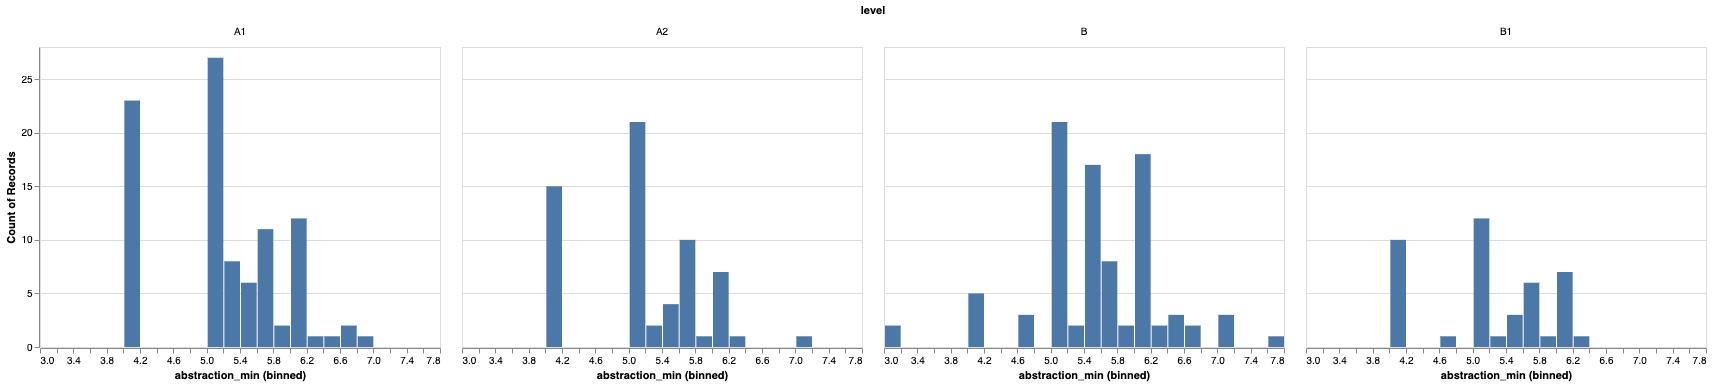

In [42]:
level_da_df = pd.DataFrame(level_degree_abstraction)
alt.Chart(level_da_df).mark_bar().encode(x = alt.X('abstraction_min', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')


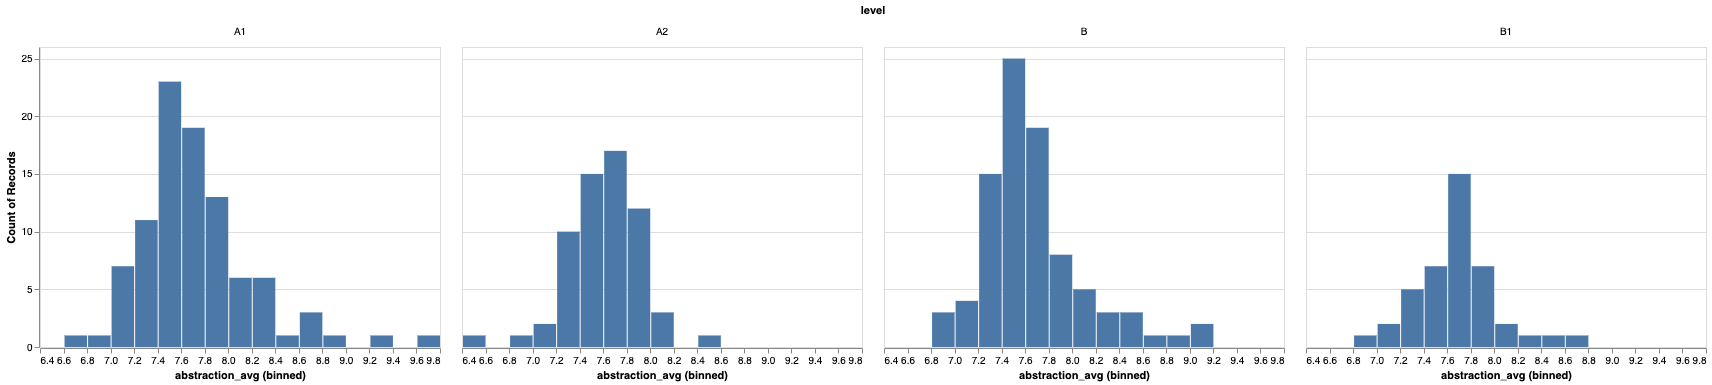

In [43]:
alt.Chart(level_da_df).mark_bar().encode(x = alt.X('abstraction_avg', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

## Degree of Ambiguation

This feature is based one of the measures suggested in the paper: "Coh-Metrix: Analysis of text on cohesion and language". 
The authors of the paper suggest that the degree of ambiguation can be measured by number of senses in WordNet. Words having many senses tend to be more ambiguous. 

We calculate the degree of ambiguousness of a Spanish text by taking the average over the number of senses in the tokens in the text. 

In [22]:
def polysemy_ambiguation(text):
    ''' This function measures degree of ambiguation of a text by counting the number of senses of each token.
    ------------------------------------------------
    Argument: text (str)
    Returns: the degree of ambiguation as mean over all tokens (the higher, more ambiguous)
             the degree of ambiguation as mean over all content tokens 
    '''
    
    sent_tokens, sent_senses = [], []
    sent_cont_tokens, sent_cont_senses = [], []
    num_senses, num_cont_senses = 0, 0

    tp = feature_pipeline(text)
    tp.get_tokens()
    tp.get_pos_tags()
    #for i_sent, sent in enumerate(tp.tokens):
    for i_token, token in enumerate(tp.tokens):
        token = token.lower()
        synsets = wncr.synsets(token)
        if len(synsets) > 0 :                                                                                              # all words 
            num_senses += len(synsets) 
            sent_tokens.append(token)                # for debugging purpose 
            sent_senses.append(len(synsets))
        if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:                # function workds 
            num_cont_senses  += len(synsets)
            sent_cont_tokens.append(token)
            sent_cont_senses.append(len(synsets))
            
    if sent_senses == []:
        return 0, 0
    
    return np.mean(sent_senses), np.mean(sent_cont_senses)            

### Tests

Shown below are test cases for polysemy_ambiguatoin function. Please note that these codes are written to make debugging easier and they are not written for efficiency.
The codes print a lot of redundant information for debugging purpose. 

#### Boundary Cases

In [23]:
text = ''
assert polysemy_ambiguation(text) == (0, 0)

In [24]:
text = '1.'
assert polysemy_ambiguation(text) == (0, 0)

#### Bruce force vs. Implementation (Simple Cases)

In [25]:
text = 'Voy a la escuela. Voy a la escuela el lunes, el martes, el miércoles, el jueves y el viernes.'
tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
num_synsets, num_tokens = 0, 0
num_cont_synsets, num_cont_tokens = 0, 0

#for i_sent, sent in enumerate(tp.tokens):
for i_token, token in enumerate(tp.tokens):
    token = token.lower()
    synsets = wncr.synsets(token)
    print(token, tp.pos_tags[i_token], synsets)
    if len(synsets) > 0:                                                                                 # all words 
        num_synsets += len(synsets)
        num_tokens += 1
    if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:   # function words 
        num_cont_synsets += len(synsets)
        num_cont_tokens += 1

print(num_synsets/num_tokens, num_cont_synsets/num_cont_tokens)  # Make sure that these are the same as the function returns. 
print(polysemy_ambiguation(text)) 

voy VERB []
a ADP [Synset('a.n.01')]
la DET [Synset('la.n.01')]
escuela NOUN [Synset('colegio.n.01'), Synset('escuela.n.02'), Synset('colegio.n.02'), Synset('colegio.n.03')]
. PUNCT []
voy VERB []
a ADP [Synset('a.n.01')]
la DET [Synset('la.n.01')]
escuela NOUN [Synset('colegio.n.01'), Synset('escuela.n.02'), Synset('colegio.n.02'), Synset('colegio.n.03')]
el DET []
lunes NOUN [Synset('lunes.n.01')]
, PUNCT []
el DET []
martes NOUN [Synset('martes.n.01'), Synset('marte.n.01')]
, PUNCT []
el DET []
miércoles NOUN [Synset('miércoles.n.01')]
, PUNCT []
el DET []
jueves NOUN [Synset('jueves.n.01')]
y CCONJ [Synset('y.n.01')]
el DET []
viernes NOUN [Synset('viernes.n.01')]
. PUNCT []
1.5833333333333333 1.7777777777777777
(1.5833333333333333, 1.7777777777777777)


In [27]:
text = corpus['A1'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
num_synsets, num_tokens = 0, 0
num_cont_synsets, num_cont_tokens = 0, 0

#for i_sent, sent in enumerate(tp.tokens):
for i_token, token in enumerate(tp.tokens):
    token = token.lower()
    synsets = wncr.synsets(token)
    #print(token, tp.pos_tags[i_token], synsets)
    if len(synsets) > 0:                                                                                 # all words 
        num_synsets += len(synsets)
        num_tokens += 1
    if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:   # function words 
        num_cont_synsets += len(synsets)
        num_cont_tokens += 1

print(num_synsets/num_tokens, num_cont_synsets/num_cont_tokens)  # Make sure that these are the same as the function returns. 
print(polysemy_ambiguation(text)) 

Me llamo María Pérez y tengo diecinueve años. Nací en Málaga, pero vivo en Granada. Soy estudiante de primer curso de Periodismo. De lunes a viernes me levanto a las siete y media, desayuno y camino hasta la universidad. Entro en clase a las nueve y salgo a la una. Al medio día, como en mi casa y veo la televisión. Por la tarde, estudio hasta las siete y después quedo con mis amigas. A nosotras nos gusta mucho el cine, el teatro y la música. Los viernes por la noche cenamos pizza y bailamos en la discoteca. Todos los sábados visito a mi familia en Málaga. El domingo por la tarde regreso a Granada y, si hace sol, salgo con mi perro a dar un paseo. ¡Me encantan los animales!
3.0714285714285716 3.586206896551724
(3.0714285714285716, 3.586206896551724)


#### Test on small examples

In [28]:
text = corpus['A2'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
num_synsets, num_tokens = 0, 0
num_cont_synsets, num_cont_tokens = 0, 0

#for i_sent, sent in enumerate(tp.tokens):
for i_token, token in enumerate(tp.tokens):
    token = token.lower()
    synsets = wncr.synsets(token)
    #print(token, tp.pos_tags[i_token], synsets)
    if len(synsets) > 0:                                                                                 # all words 
        num_synsets += len(synsets)
        num_tokens += 1
    if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:   # function words 
        num_cont_synsets += len(synsets)
        num_cont_tokens += 1

print(num_synsets/num_tokens, num_cont_synsets/num_cont_tokens)  # Make sure that these are the same as the function returns. 
print(polysemy_ambiguation(text)) 

Capítulo I 
Que trata de la condición y ejercicio del famoso
hi dalgo don Quijote de la Mancha  
 de cuyo nombre no 
quiero acordarme, no ha mucho tiempo que vivía un hidalgo 
de los de lanza en astillero, adarga antigua, rocín flaco y galgo 
corredor. Una olla de algo más vaca que carnero, salpicón las 
más noches, duelos y quebrantos los sábados, lentejas los 
viernes, algún palomino de añadidura los domingos, consumían 
las tres partes de su hacienda. El resto della concluían sayo 
de velarte, calzas de velludo para las fiestas, con sus pantu-
flos de lo mesmo, y los días de entresemana se honraba consu 
vellorí de lo más fino. Tenía en su casa una ama que pasaba  
de los cuarenta, y una sobrina que no llegaba a los veinte, y 
un mozo de campo y plaza, que así ensillaba el rocín como 
tomaba la podadera. Frisaba la edad de nuestro hidalgo con los  
cincuenta años; era de complexión recia, seco de carnes, enjuto de 
rostro, gran madrugador y amigo de la caza. Quieren decir que tenía 

In [29]:
text = corpus['B1'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
num_synsets, num_tokens = 0, 0
num_cont_synsets, num_cont_tokens = 0, 0

#for i_sent, sent in enumerate(tp.tokens):
for i_token, token in enumerate(tp.tokens):
    token = token.lower()
    synsets = wncr.synsets(token)
    #print(token, tp.pos_tags[i_token], synsets)
    if len(synsets) > 0:                                                                                 # all words 
        num_synsets += len(synsets)
        num_tokens += 1
    if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:   # function words 
        num_cont_synsets += len(synsets)
        num_cont_tokens += 1

print(num_synsets/num_tokens, num_cont_synsets/num_cont_tokens)  # Make sure that these are the same as the function returns. 
print(polysemy_ambiguation(text)) 

Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad. Primero, caminó por La Rambla, la calle más famosa de Barcelona, llena de gente, tiendas y restaurantes. Se dirigió al Barrio Gótico, uno de los sitios más antiguos y bellos de la ciudad. En la Plaza Sant Jaume observó dos de los edificios más importantes: El Palacio de la Generalitat de Catalunya y el Ayuntamiento. Volvió a La Rambla. Mark tenía hambre y se detuvo a comer unas tapas y beber una cerveza. Continuó hasta la grande y hermosa Plaza de Catalunya. Avanzó por el Paseo de Gràcia hasta llegar a un edificios fuera de lo común Casa Batlló y luego a Casa Milà, diseños del arquitecto Antoni Gaudí. Quiso saber más sobre este famoso arquitecto y se dirigió al Park Güell, donde tomó muchas fotografías. El día se acababa pero antes de volver al hotel, Mark tomó un taxi hacia la Fuente Mágica y disfrutó de un espectáculo de agua y luces. Mark quedó sorprendido con esta gran ciudad y sintió qu

In [30]:
text = corpus['B'][0]['content']
print(text)

tp = feature_pipeline(text)
tp.get_tokens()
tp.get_pos_tags()
num_synsets, num_tokens = 0, 0
num_cont_synsets, num_cont_tokens = 0, 0

#for i_sent, sent in enumerate(tp.tokens):
for i_token, token in enumerate(tp.tokens):
    token = token.lower()
    synsets = wncr.synsets(token)
    #print(token, tp.pos_tags[i_token], synsets)
    if len(synsets) > 0:                                                                                 # all words 
        num_synsets += len(synsets)
        num_tokens += 1
    if tp.pos_tags[i_token] in {"VERB", "NOUN", "PROPN", "ADP", "ADJ", "ADV"} and len(synsets) > 0:   # function words 
        num_cont_synsets += len(synsets)
        num_cont_tokens += 1

print(num_synsets/num_tokens, num_cont_synsets/num_cont_tokens)  # Make sure that these are the same as the function returns. 
print(polysemy_ambiguation(text)) 

 
ABENÁMAR
Abenámar, Abenámar,
moro de la morería,
el día que tú naciste
grandes señales había!5
Estaba la mar en calma,
la luna estaba crecida:
moro que en tal signo nace,
no debe decir mentira.—
Allí respondiera el moro,10
bien oiréis lo que decía:
—Yo te la diré, señor,
aunque me cueste la vida,
porque soy hijo de un moro
y una cristiana cautiva;15
siendo yo niño y muchacho
mi madre me lo decía:
que mentira no dijese,
que era grande villanía:2
por tanto pregunta, rey,
que la verdad te diría.
—Yo te agradezco, Abenámar
aquesa tu cortesía.
¿Qué castillos son aquéllos?5
¡Altos son y relucían!
—El Alhambra era, señor,
y la otra la mezquita;
los otros los Alixares,
labrados á maravilla.10
El moro que los labraba
cien doblas ganaba al día,
y el día que no los labra
otras tantas se perdía.
El otro es Generalife,15
huerta que par no tenía;
el otro Torres Bermejas,
castillo de gran valía.—
Allí habló el rey don Juan,
bien oiréis lo que decía:20
—Si tú quisieses, Granada,
contigo me casaría;


### Run through Corpora

In [31]:
level_list = ['A1', 'A2', 'B', 'B1']
level_degree_ambig = defaultdict(list)
for level in level_list:
    corpus_item = corpus[level]
    for i, text_item in enumerate(corpus_item):
        try: 
            am_avg, am_cont = polysemy_ambiguation(text_item['content'])
            level_degree_ambig['level'].append(level)
            level_degree_ambig['ambiguity_avg'].append(am_avg)    # pick out the most abstract word in each text 
            level_degree_ambig['ambiguity_cont'].append(am_cont)    # average abstractness in each text 
            
        except:
            print(f'Error', level, i)
            pass

### Plot Distributions

We plot the ambiguity distribution by text difficulty level.

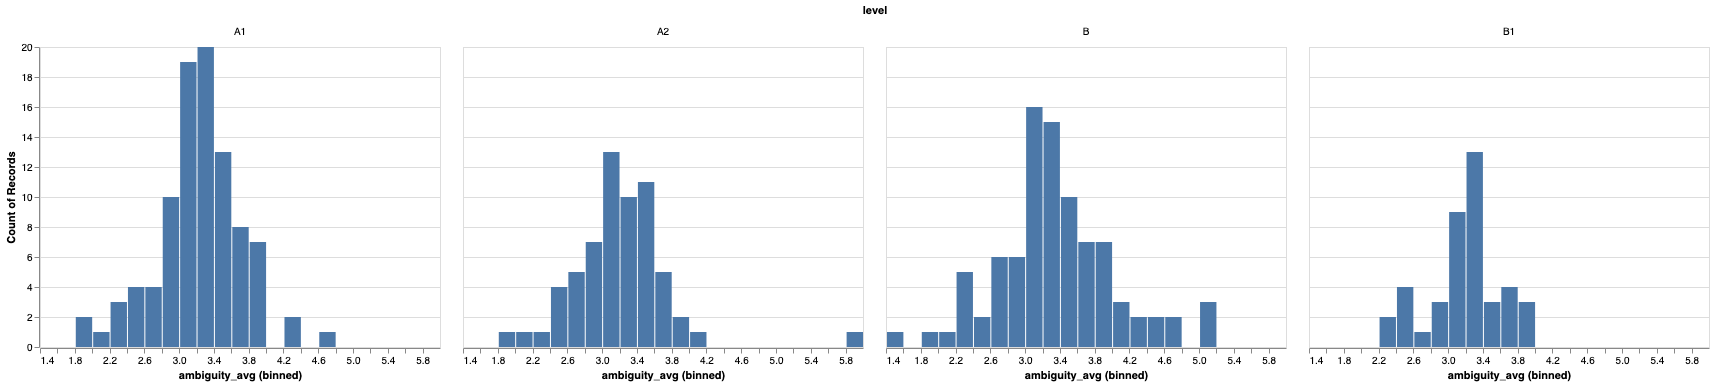

In [32]:
level_amb_df = pd.DataFrame(level_degree_ambig)
level_amb_df.head()
alt.Chart(level_amb_df).mark_bar().encode(x = alt.X('ambiguity_avg', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

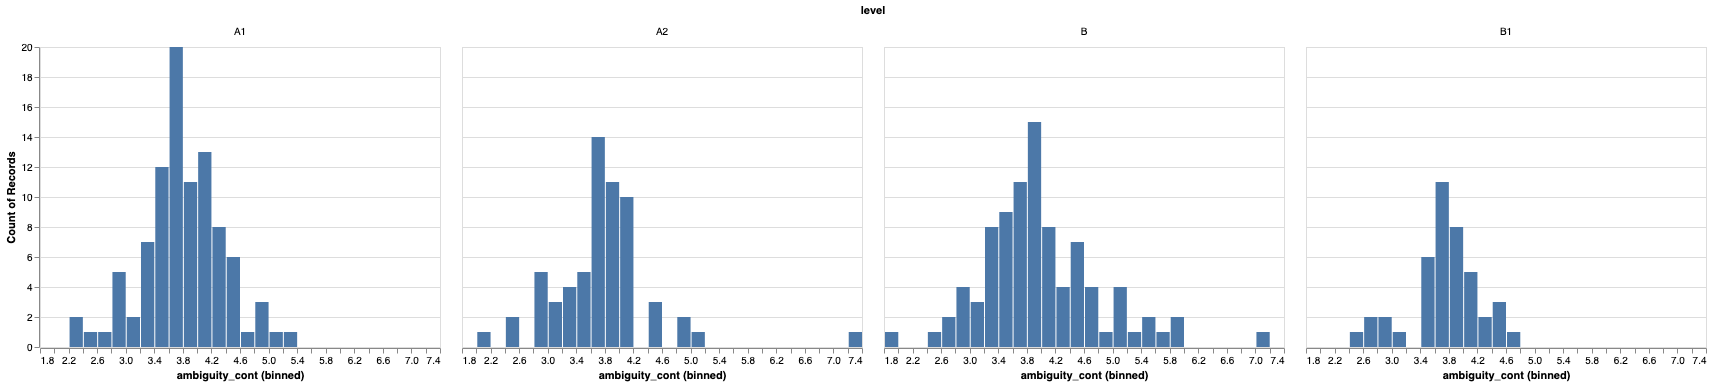

In [33]:
alt.Chart(level_amb_df).mark_bar().encode(x = alt.X('ambiguity_cont', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')